#  Applied Machine Learning 

## Homework 5: Evaluation metrics


## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay
)
from sklearn import set_config

set_config(display="diagram")
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 2 | 8 |
| **Actual no disease**       | 0 | 100 |


- Model B

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 6 | 4 |
| **Actual no disease**       | 10 | 90 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [2]:
acuuA = (2+100)/110
acuuB = (6+90)/110

In [3]:
results_dict = {"A": {}, "B": {}}

In [4]:
results_dict["A"]["accuracy"] = acuuA
results_dict["B"]["accuracy"] = acuuB



In [5]:
assert tests_hw5.ex1_2_1(
    results_dict["A"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [6]:
assert tests_hw5.ex1_2_2(
    results_dict["B"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [7]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727


In [8]:
results_dict

{'A': {'accuracy': 0.9272727272727272}, 'B': {'accuracy': 0.8727272727272727}}

<br><br>

### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

In [9]:
# Calculating RECALL here,
recA = 2/(2+8)
recB = 6/(6+4)
print(recA,recB)

0.2 0.6


In [10]:
# Model B is good compare to A

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [11]:
preA = 2/2
preB = (6)/16

In [12]:
def f1(precision,recall):
    f1 = 2*precision*recall/(precision+recall)
    return f1

In [13]:
f1(preA,recA)

0.33333333333333337

In [14]:
results_dict["A"]["precision"] = preA
results_dict["B"]["precision"] = preB
results_dict["A"]["recall"] = recA
results_dict["B"]["recall"] = recB
results_dict["A"]["f1"] = f1(preA,recA)
results_dict["B"]["f1"] = f1(preB,recB)




In [15]:
assert tests_hw5.ex1_4_1(
    results_dict["A"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [16]:
assert tests_hw5.ex1_4_2(
    results_dict["B"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [17]:
assert tests_hw5.ex1_4_3(
    results_dict["A"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [18]:
assert tests_hw5.ex1_4_4(
    results_dict["B"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [19]:
assert tests_hw5.ex1_4_5(
    results_dict["A"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [20]:
assert tests_hw5.ex1_4_6(
    results_dict["B"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


Show the dataframe with all results. 

In [21]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727
precision,1.000000,0.375000
recall,0.200000,0.600000
f1,0.333333,0.461538


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 4 to 5 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [22]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [23]:
train_df["churn"].value_counts(normalize=True)

False    0.850407
True     0.149593
Name: churn, dtype: float64

In [24]:
# kind of inbalance

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1402 to 1346
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null

In [26]:
train_df['state'].value_counts()

WV    70
NY    64
OR    59
TX    59
OH    58
MN    58
MI    57
CT    54
MT    54
WY    54
WI    54
MD    53
AL    51
ID    51
VT    51
NJ    50
AZ    50
ME    49
UT    48
RI    48
FL    48
MA    47
ND    47
DE    46
NC    45
OK    45
AR    44
KS    44
MS    43
VA    43
MO    43
NM    43
IN    42
GA    41
KY    41
AK    40
NH    40
IL    39
CO    39
SC    39
SD    39
NV    39
TN    38
DC    38
NE    38
WA    34
PA    34
HI    33
LA    31
IA    30
CA    28
Name: state, dtype: int64

<br><br>

### 2.3 Column transformer 
rubric={points:10}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [27]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [28]:
X_train

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,204.7,77,17.40,256.6,101,11.55,5.7,4,1.54,1
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,142.3,76,12.10,91.2,86,4.10,10.9,5,2.94,2
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,89.7,103,7.62,220.0,91,9.90,15.6,4,4.21,2
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,163.1,105,13.86,282.5,100,12.71,10.0,3,2.70,1
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,261.5,95,22.23,241.6,104,10.87,11.4,9,3.08,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,246.5,112,20.95,285.3,104,12.84,12.5,8,3.38,2
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,170.0,92,14.45,127.9,68,5.76,9.4,4,2.54,3
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,139.8,121,11.88,171.6,96,7.72,11.6,7,3.13,2
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,246.1,147,20.92,242.0,106,10.89,10.4,5,2.81,1


In [29]:
category_col = ['state','area code']
binary = ['international plan','voice mail plan']
drop = ['phone number']
numeric_col = list(set(X_train.columns) - set(category_col) - set(binary) - set(drop))

# ohe_columns = ['state','international plan','voice mail plan']
# scale_columns = [ 'account length', 'number vmail messages',
#        'total day minutes', 'total day calls', 'total day charge',
#        'total eve minutes', 'total eve calls', 'total eve charge',
#        'total night minutes', 'total night calls', 'total night charge',
#        'total intl minutes', 'total intl calls', 'total intl charge',
#        'customer service calls']              

# drop_columns = ['phone number']

In [30]:
ct = make_column_transformer(
    
        (make_pipeline(StandardScaler()),numeric_col),
        ('drop',drop),
        (OneHotEncoder(handle_unknown="ignore",dtype=int,sparse=False),category_col),
        (OneHotEncoder(drop="if_binary",handle_unknown="ignore",dtype=int,sparse=False),binary)  
)

ct


ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['number vmail messages', 'account length',
                                  'total day minutes', 'customer service calls',
                                  'total day charge', 'total night charge',
                                  'total intl calls', 'total intl charge',
                                  'total night minutes', 'total eve charge',
                                  'total night calls', 'total eve minutes',
                                  'total day calls', 'total intl minutes',
                                  'total eve calls']),
                                ('drop', 'drop', ['phone number']),
                                ('onehotencoder-1',
                                 OneHotEncoder(dtype=<class 'int'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['state', 'area code']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['international plan', 'voice mail plan'])])

### 2.4 Visualizing the transformed data 
rubric={points:4}

Fit and transform your `ColumnTransformer` on your training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array). See lecture 10 for code that can get you the new column names after transforming. 

In [31]:
x =(ct.fit_transform(X_train))

C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
column =numeric_col+ct.named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()+ct.named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()

In [33]:
pd.DataFrame(x,columns=column)

,number vmail messages,account length,total day minutes,customer service calls,total day charge,total night charge,total intl calls,total intl charge,total night minutes,total eve charge,...,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,-0.587624,-0.767893,0.618769,-0.415269,0.618927,1.089926,-0.200722,-1.644994,1.088667,0.069926,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.587624,-0.843585,-1.293778,0.337507,-1.293517,-2.164029,0.198158,0.222249,-2.162302,-1.166291,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.900976,0.544113,-0.609809,0.337507,-0.609654,0.369252,-0.200722,1.916105,0.369287,-2.211244,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.587624,0.165650,0.998345,-0.415269,0.998611,1.596582,-0.599603,-0.097850,1.597736,-0.755774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,-0.587624,0.115188,-0.994886,0.337507,-0.994731,0.792921,1.793679,0.408973,0.793839,1.196515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.587624,0.645037,0.329045,0.337507,0.328771,1.653363,1.394799,0.809096,1.652771,0.897957,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2329,1.608200,-0.767893,-0.664820,1.090282,-0.664665,-1.438987,-0.200722,-0.311249,-1.440956,-0.618157,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2330,-0.587624,0.619806,0.048489,0.337507,0.048322,-0.582913,0.995918,0.475660,-0.582024,-1.217606,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2331,-0.587624,1.477656,0.173180,-0.415269,0.173445,0.801656,0.198158,0.048862,0.801701,0.890960,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<br><br>

### 2.5 area code feature
rubric={points:4}

The original dataset had a feature called `area code`. Let's assume we encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?
2. What were the possible values of `area code`? 
3. What new feature(s) were created to replace `area code`? 

In [34]:
# ans:1 , unioque 3 values, can repreent with OHE
# ans:2 , 
train_df['area code'].unique()

array([415, 510, 408], dtype=int64)

In [35]:
# ans:3 , area code_415, area code_510, area code_408

<br><br>

### 2.6 Dummy classifier
rubric={points:4}

**Your tasks:**

Create a `DummyClassifier`. Report the following scoring metrics via cross-validation: accuracy, precision, recall, f1-score. Briefly comment on your results, including any warnings the code produces (2 sentences max).

In [36]:
pip01 = make_pipeline(ct,DummyClassifier())

In [37]:
score = cross_validate(pip01, X_train, y_train,return_train_score=True)

pd.DataFrame(score)

C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

,fit_time,score_time,test_score,train_score
0,0.021137,0.011560,0.850107,0.850482
1,0.016347,0.008929,0.850107,0.850482
2,0.021509,0.014247,0.850107,0.850482
3,0.019982,0.009998,0.851931,0.850027
4,0.017216,0.008651,0.849785,0.850562


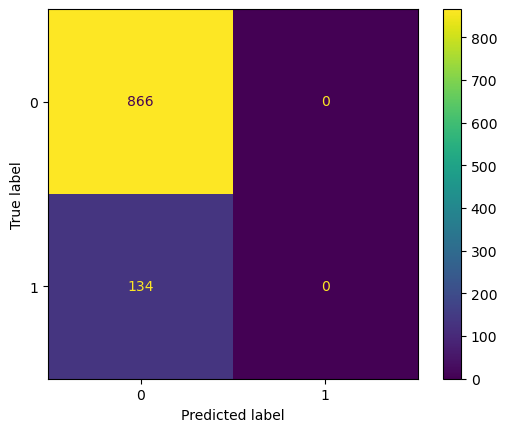

In [38]:
dm = DummyClassifier()
dm.fit(X_train,y_train)

ConfusionMatrixDisplay( confusion_matrix(y_test,dm.predict(X_test))).plot()

In [39]:
print(classification_report(y_test,dm.predict(X_test)))

              precision    recall  f1-score   support

       False       0.87      1.00      0.93       866
        True       0.00      0.00      0.00       134

    accuracy                           0.87      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.75      0.87      0.80      1000



C:\Users\pd846\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<br><br>

### 2.7 Logistic regression
rubric={points:8} 

**Your tasks:**

1. Train and score a logistic regression classifier on the dataset. 
2. Report the same metrics as in the previous part.
3. Are you satisfied with the results? Use your `DummyClassifier` results as a reference point. Discuss in a few sentences. 

In [40]:
pip02 = make_pipeline(ct,LogisticRegression())

In [41]:
score1 = cross_validate(pip02,X_train,y_train,return_train_score=True)

C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

In [42]:
pd.DataFrame(score1)

,fit_time,score_time,test_score,train_score
0,0.109816,0.012715,0.869379,0.864416
1,0.098356,0.008070,0.852248,0.868167
2,0.076938,0.009672,0.850107,0.867095
3,0.074852,0.009598,0.869099,0.863953
4,0.089092,0.010084,0.839056,0.868773


In [43]:
pip02.fit(X_train,y_train)



C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['number vmail messages',
                                                   'account length',
                                                   'total day minutes',
                                                   'customer service calls',
                                                   'total day charge',
                                                   'total night charge',
                                                   'total intl calls',
                                                   'total intl charge',
                                                   'total night minutes',
                                                   'total eve charge',
                                                   'total night calls',
                                                   'total eve...
                                                   'total eve calls']),
                                                 ('drop', 'drop',
                                                  ['phone number']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['state', 'area code']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['international plan',
                                                   'voice mail plan'])])),
                ('logisticregression', LogisticRegression())])

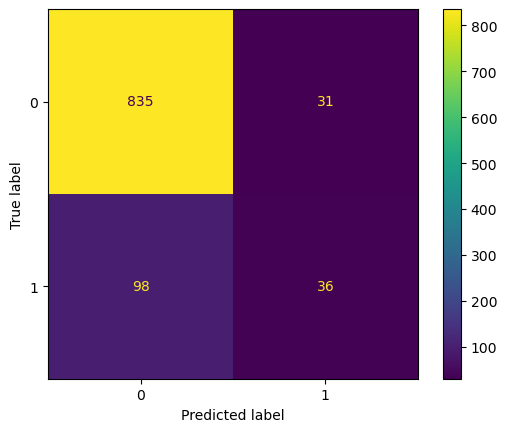

In [44]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pip02.predict(X_test))).plot()

In [45]:
print(classification_report(y_test,pip02.predict(X_test)))

              precision    recall  f1-score   support

       False       0.89      0.96      0.93       866
        True       0.54      0.27      0.36       134

    accuracy                           0.87      1000
   macro avg       0.72      0.62      0.64      1000
weighted avg       0.85      0.87      0.85      1000



<br><br>

### 2.8 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences.

In [46]:
pip03 = make_pipeline(ct,LogisticRegression(class_weight='balanced'))

In [47]:
score2 = cross_validate(pip03,X_train,y_train,return_train_score=True)

C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

In [48]:
pd.DataFrame(score2)

,fit_time,score_time,test_score,train_score
0,0.101564,0.009853,0.785867,0.769561
1,0.080265,0.009640,0.768737,0.771168
2,0.081115,0.006631,0.764454,0.774384
3,0.082019,0.011713,0.751073,0.779325
4,0.124084,0.011322,0.733906,0.786824


In [49]:
pip03.fit(X_train,y_train)



C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['number vmail messages',
                                                   'account length',
                                                   'total day minutes',
                                                   'customer service calls',
                                                   'total day charge',
                                                   'total night charge',
                                                   'total intl calls',
                                                   'total intl charge',
                                                   'total night minutes',
                                                   'total eve charge',
                                                   'total night calls',
                                                   'total eve...
                                                 ('drop', 'drop',
                                                  ['phone number']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['state', 'area code']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['international plan',
                                                   'voice mail plan'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

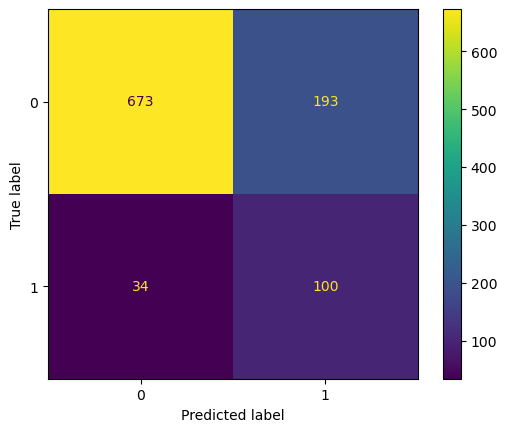

In [50]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pip03.predict(X_test))).plot()

In [51]:
print(classification_report(y_test,pip03.predict(X_test)))

              precision    recall  f1-score   support

       False       0.95      0.78      0.86       866
        True       0.34      0.75      0.47       134

    accuracy                           0.77      1000
   macro avg       0.65      0.76      0.66      1000
weighted avg       0.87      0.77      0.80      1000



<br><br>

### 2.9 Hyperparameter optimization
rubric={points:10}

Now let's tune the hyperparameters of our `LogisticRegression` using `GridSearchCV` to maximize cross-validation f1 score. 

**Your tasks:**

1. Jointly optimize `C` (choose some reasonable values) and `class_weight` (`None` vs. `'balanced'`) with `GridSearchCV` and `scoring="f1"`. 
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [52]:
prams = {
    'logisticregression__C':[0.01,0.1,1,10,100],
    'logisticregression__class_weight':['balanced',None]
}

In [53]:
pipee = make_pipeline(ct,LogisticRegression())

In [54]:
grid_search = GridSearchCV(pipee,prams,verbose=3,n_jobs=-1,return_train_score=True,scoring=['f1','r2'],refit=False)

In [55]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\pd846\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'account '
                                                                          'length',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'customer '
                                                                          'service '
                                                                          'calls',
                                                                          'total '
                                                                          'day '
                                                                          'charge',
                                                                          'total '
                                                                          'night '
                                                                          'charge',
                                                                          'total '
                                                                          'intl '
                                                                          'calls',
                                                                          'total '
                                                                          'intl '
                                                                          'charge',
                                                                          'total '
                                                                          'nig...
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype=<class 'int'>,
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan'])])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'logisticregression__class_weight': ['balanced',
                                                              None]},
             refit=False, return_train_score=True, scoring=['f1', 'r2'],
             verbose=3)

In [56]:
pd.DataFrame(grid_search.cv_results_).T[2]['params']
# best parameters


{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}

<br><br>

### 2.10 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 
3. Comment on the results.    

> Note that we are not doing it here but in real life, you would also plot confusion matrix, precision-recall curve, and ROC curve on validation data to examine errors and to choose a threshold which works for your operating point. 

In [57]:
pip02.fit(X_train,y_train)

C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\pd846\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['number vmail messages',
                                                   'account length',
                                                   'total day minutes',
                                                   'customer service calls',
                                                   'total day charge',
                                                   'total night charge',
                                                   'total intl calls',
                                                   'total intl charge',
                                                   'total night minutes',
                                                   'total eve charge',
                                                   'total night calls',
                                                   'total eve...
                                                   'total eve calls']),
                                                 ('drop', 'drop',
                                                  ['phone number']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['state', 'area code']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['international plan',
                                                   'voice mail plan'])])),
                ('logisticregression', LogisticRegression())])

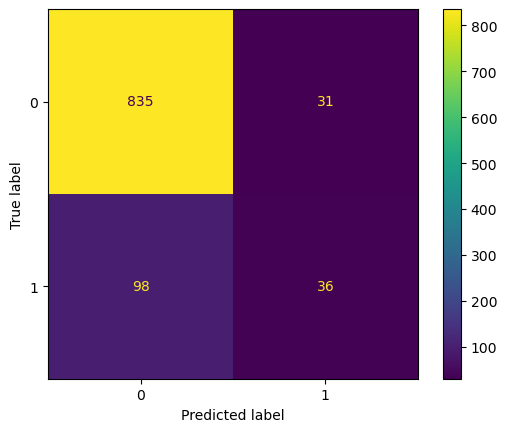

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pip02.predict(X_test))).plot()

In [59]:
print(classification_report(y_test,pip02.predict(X_test)))

              precision    recall  f1-score   support

       False       0.89      0.96      0.93       866
        True       0.54      0.27      0.36       134

    accuracy                           0.87      1000
   macro avg       0.72      0.62      0.64      1000
weighted avg       0.85      0.87      0.85      1000



In [60]:
pip02.classes_


array([False,  True])

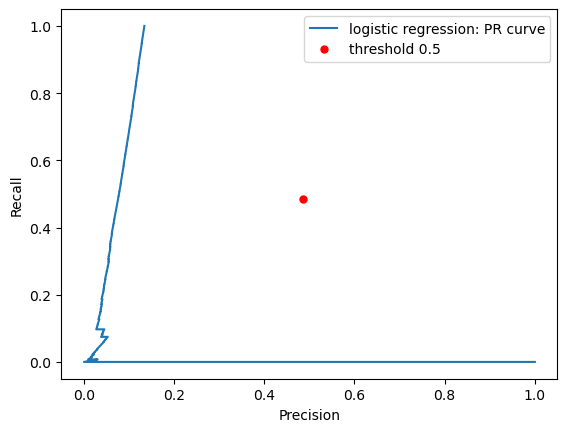

In [61]:
# from sklearn.metrics import PrecisionRecallDisplay

# display = PrecisionRecallDisplay.from_estimator(
#     pip02, X_test, y_test, name="Logi"
# )
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
#     y_valid, pipe_lr.predict_proba(X_valid)
    y_test,pip02.predict_proba(X_test)[:, 0]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test,pip02.predict_proba(X_test)[:, 1]>0.307602),
    recall_score(y_test,pip02.predict_proba(X_test)[:, 1]>0.307602),
    "or",
    markersize=5,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [62]:
a = pd.DataFrame([precision,recall,thresholds],index=['precision','recall','threshold']).T
a['diff'] = abs(a.precision - a.recall)
a.sort_values(by=['diff'],ascending=False)

,precision,recall,threshold,diff
1000,1.000000,0.000000,NaN,1.000000
0,0.134000,1.000000,0.024948,0.866000
1,0.133133,0.992537,0.051242,0.859404
2,0.132265,0.985075,0.073935,0.852810
3,0.131394,0.977612,0.103444,0.846218
...,...,...,...,...
970,0.000000,0.000000,0.992216,0.000000
969,0.000000,0.000000,0.992150,0.000000
968,0.000000,0.000000,0.992141,0.000000
866,0.022388,0.022388,0.979489,0.000000


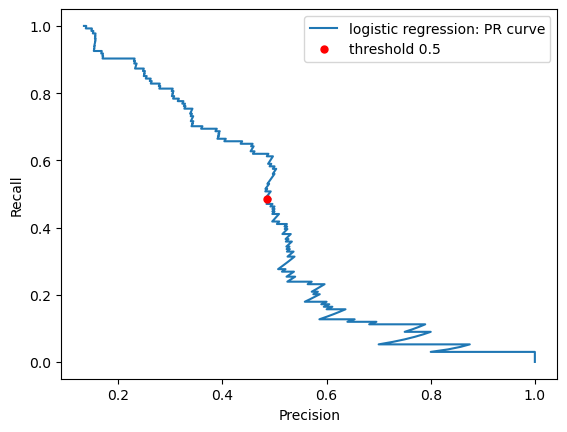

In [63]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
#     y_valid, pipe_lr.predict_proba(X_valid)
    y_test,pip02.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test,pip02.predict_proba(X_test)[:, 1]>0.307602),
    recall_score(y_test,pip02.predict_proba(X_test)[:, 1]>0.307602),
    "or",
    markersize=5,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [64]:
a = pd.DataFrame([precision,recall,thresholds],index=['precision','recall','threshold']).T
a['diff'] = abs(a.precision - a.recall)
a.sort_values(by=['diff'],ascending=True)

,precision,recall,threshold,diff
866,0.485075,0.485075,0.307602,0.000000
867,0.488722,0.485075,0.309395,0.003647
865,0.488889,0.492537,0.305184,0.003648
864,0.485294,0.492537,0.304851,0.007243
868,0.492424,0.485075,0.310935,0.007350
...,...,...,...,...
996,1.000000,0.029851,0.896556,0.970149
997,1.000000,0.022388,0.926065,0.977612
998,1.000000,0.014925,0.948758,0.985075
999,1.000000,0.007463,0.975052,0.992537


In [65]:
pip02.classes_

array([False,  True])

In [66]:
pip02.predict_proba(X_test) 

array([[0.26464454, 0.73535546],
       [0.88710707, 0.11289293],
       [0.98278757, 0.01721243],
       ...,
       [0.79481033, 0.20518967],
       [0.8063778 , 0.1936222 ],
       [0.74751201, 0.25248799]])

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [68]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

In [69]:
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [105]:
train_df1,test_df1 = train_test_split(housing_df,test_size=0.2,random_state=123)

In [106]:
ct1 =make_column_transformer(
    (StandardScaler(),X_test1.columns)
)
ct1

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])

In [107]:
X_train1 = train_df1.drop(columns=['MedHouseVal'])
y_train1 = train_df1['MedHouseVal']
X_test1 = test_df1.drop(columns=['MedHouseVal'])
y_test1 = train_df1['MedHouseVal']

<br><br>

### 3.2 Baseline: DummyRegressor 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `DummyRegressor` with default scoring. 
2. What metric is used for scoring by default? 

In [108]:
pipdum = make_pipeline(ct,DummyRegressor())

In [109]:
scoredummy = cross_validate(pipdum,X_train1,y_train1,cv=5,return_train_score=True)

In [110]:
pd.DataFrame(scoredummy)

,fit_time,score_time,test_score,train_score
0,0.011104,0.005161,-0.000023,0.0
1,0.010979,0.004057,-0.000576,0.0
2,0.007604,0.003598,-0.000061,0.0
3,0.008594,0.003002,-0.000015,0.0
4,0.007523,0.003537,-0.000058,0.0


In [111]:
# default scorring method in cv while regression is R2 scorring method.b


<br><br>

### 3.3 Different regressors
rubric={points:8}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [181]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [182]:
models

{'Ridge': Ridge(), 'Random Forest': RandomForestRegressor()}

In [183]:
len(models)

2

In [184]:
result_dict = {
    
}
for m in models:
    model = make_pipeline(ct1,models[m])
    res = cross_validate(model,X_train1,y_train1,cv=5,scoring=score_types_reg)
    for i in res:
        res[i] = res[i].mean()
    result_dict[m] = res

In [185]:
pd.DataFrame(result_dict)

,Ridge,Random Forest
fit_time,0.013191,22.124324
score_time,0.007504,0.153863
test_neg_mean_squared_error,-0.683433,-0.263494
test_neg_root_mean_squared_error,-0.810381,-0.513220
test_neg_mean_absolute_error,-0.535444,-0.334802
test_r2,0.481744,0.801956
test_mape_scorer,-31.979551,-18.923282


<br><br>

### (Optional) 3.4 Hyperparameter optimization 
rubric={points:1}

**Your tasks:**
1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose the metric of your choice for hyperparameter optimization. 
2. Are you getting better scores compared to the default values?

In [190]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

In [192]:
pipridge = make_pipeline(ct1,Ridge())

In [194]:
rscv = RandomizedSearchCV(pipridge,param_dist,cv=5,verbose=3,n_jobs=-1,return_train_score=True,scoring='r2')

In [202]:
rscv.fit(X_train1,y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D7FCE7DBD0>},
                   return_train_score=True, scoring='r2', verbose=3)

In [ ]:
rscv.

In [203]:
pd.DataFrame(rscv.cv_results_).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.022261,0.020228,0.0161,0.014076,0.013915,0.013299,0.011338,0.013171,0.015602,0.01256
std_fit_time,0.004444,0.002034,0.001743,0.001844,0.001362,0.000529,0.001622,0.00211,0.003443,0.00063
mean_score_time,0.004076,0.003728,0.003081,0.003645,0.004316,0.003918,0.004553,0.005128,0.004022,0.004187
std_score_time,0.000248,0.000688,0.000934,0.000979,0.000607,0.000501,0.000588,0.001013,0.00064,0.000204
param_ridge__alpha,2.340389,0.352023,4.340107,0.517432,189.564641,284.182884,0.037741,294.947915,9.196702,261.436379
params,{'ridge__alpha': 2.3403888600872174},{'ridge__alpha': 0.3520225259171142},{'ridge__alpha': 4.340106540962417},{'ridge__alpha': 0.5174319871143984},{'ridge__alpha': 189.5646412994631},{'ridge__alpha': 284.18288351874264},{'ridge__alpha': 0.03774094663417996},{'ridge__alpha': 294.9479145032137},{'ridge__alpha': 9.196701567262348},{'ridge__alpha': 261.43637873299366}
split0_test_score,0.600785,0.6007,0.60087,0.600707,0.604491,0.604259,0.600686,0.604177,0.601069,0.604398
split1_test_score,0.609358,0.609399,0.609317,0.609396,0.603711,0.60016,0.609405,0.599744,0.609213,0.601032
split2_test_score,0.611167,0.611168,0.611165,0.611168,0.608607,0.606254,0.611168,0.605964,0.611158,0.606855
split3_test_score,0.599977,0.599997,0.599957,0.599996,0.595704,0.592559,0.6,0.592182,0.599903,0.593345


In [204]:
# yes getting best results with parameter
rscv.best_params_

{'ridge__alpha': 0.03774094663417996}

<br><br>

### 3.5 Test results
rubric={points:4}

**Your tasks:**

1. Try the best model on the test set.
2. Briefly comment on the results. (1 to 2 sentences) 

In [224]:
piprand = make_pipeline(ct1,RandomForestRegressor(n_jobs=-1))
prms1 = {'randomforestregressor__n_estimators': [100,200,400,700,1000],
        }
gs =GridSearchCV(piprand,prms1,n_jobs=-1,cv=5,verbose=3,scoring='r2',return_train_score=True)

In [225]:
gs.fit(X_train1,y_train1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [100, 200, 400,
                                                                 700, 1000]},
             return_train_score=True, scoring='r2', verbose=3)

In [226]:
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4
mean_fit_time,42.736962,48.714459,58.551084,90.57307,57.559177
std_fit_time,5.598567,2.770473,4.291852,1.514243,1.064568
mean_score_time,13.240772,11.350326,8.403866,7.198733,1.455713
std_score_time,1.299169,1.320184,0.969682,0.461765,1.877962
param_randomforestregressor__n_estimators,100,200,400,700,1000
params,{'randomforestregressor__n_estimators': 100},{'randomforestregressor__n_estimators': 200},{'randomforestregressor__n_estimators': 400},{'randomforestregressor__n_estimators': 700},{'randomforestregressor__n_estimators': 1000}
split0_test_score,0.814865,0.817615,0.817309,0.817862,0.817937
split1_test_score,0.804998,0.805572,0.807186,0.806801,0.807563
split2_test_score,0.812364,0.810704,0.811927,0.812037,0.812673
split3_test_score,0.785699,0.789175,0.787229,0.786695,0.786763


In [231]:
piprand1 = make_pipeline(ct1,RandomForestRegressor(n_jobs=-1))
prms11 = {'randomforestregressor__n_estimators': [10,50,1200,1500,2000],
        }
gs1 =GridSearchCV(piprand1,prms11,n_jobs=-1,cv=5,verbose=3,scoring='r2',return_train_score=True)

In [232]:
gs1.fit(X_train1,y_train1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 50, 1200,
                                                                 1500, 2000]},
             return_train_score=True, scoring='r2', verbose=3)

# 

# 

In [233]:
pd.DataFrame(gs1.cv_results_).T

,0,1,2,3,4
mean_fit_time,92.605404,37.629932,218.02289,223.03659,198.36689
std_fit_time,50.029677,38.894989,32.156479,14.057586,6.240451
mean_score_time,48.491695,40.630995,34.274499,52.425434,3.399418
std_score_time,33.286364,22.232378,3.573137,6.404963,1.875861
param_randomforestregressor__n_estimators,10,50,1200,1500,2000
params,{'randomforestregressor__n_estimators': 10},{'randomforestregressor__n_estimators': 50},{'randomforestregressor__n_estimators': 1200},{'randomforestregressor__n_estimators': 1500},{'randomforestregressor__n_estimators': 2000}
split0_test_score,0.796595,0.813324,0.817816,0.817626,0.817763
split1_test_score,0.782868,0.802375,0.807522,0.807643,0.807329
split2_test_score,0.79349,0.810892,0.812792,0.813009,0.812017
split3_test_score,0.754553,0.78106,0.787662,0.787838,0.787438


In [ ]:
# best model is RandomForestRegressor with hyperparamerter n_estimator=1500

<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. If you attempted 3.4, use the `Ridge` model with best hyperparameters. Otherwise use the `Ridge` model with default hyperparameters. 
2. Increasing which feature values would result in higher housing price? 

In [257]:
cf= rscv.best_estimator_.named_steps['ridge'].coef_
cf

array([ 0.83600863,  0.11522435, -0.28189414,  0.31828085, -0.00740297,
       -0.04168268, -0.89012111, -0.85552045])

<Axes: >

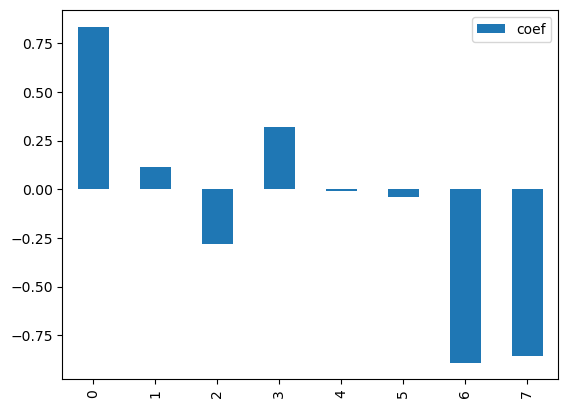

In [256]:
pd.DataFrame(cf,columns=['coef']).plot(kind='bar')

In [258]:
# feature 6 has most impact on predict the housing price

<br><br>